# Chapitre 1

L'idée avec ce Chapitre c'est de pouvoir explorer le dataset dans sa globalité, essayer d'étudier les différentes corrélations entre les données et de pouvoir trouver des premiers insights ou patterns qui nous serviront par la suite pour le traitement de ces données

1. Data Exploration
2. Data Interpretation
3. Data Quality Problems
4. Data Cleaning
5. Text Processing
6. Data Transformation
7. Manifold Learning
8. Visualisation & Conclusions

In [3]:
import pandas as pd 
import polars as pl

In [4]:
"""Chargement du dataset en mode snapshot 
La data choisie est le 20-10-2025, certaines données peuvent varier mais pour l'instant on part du principe que ce dataset est représentatif
pour les travaux à venir"""

#Chargement du snapshot va se faire avec pandas mais à terme on va migrer sur du polars ...  ,
# plus rapide et avec du multithreading mais on va devoir faire du casting vers pandas pour les librairies comme scikit ou seaborn ... 

SNAPSHOT = "snapshot_dataset_20_10_2025.csv"
CHEMIN_FICHIER = f"./data/{SNAPSHOT}"  

DATASET = pd.read_csv(CHEMIN_FICHIER)
print(DATASET.shape)
print(DATASET.dtypes)

(28180, 18)
Timestamp                                                                                                                                                                                                                                object
How old are you?                                                                                                                                                                                                                         object
What industry do you work in?                                                                                                                                                                                                            object
Job title                                                                                                                                                                                                                                object
If your job title needs addi

Affichage des informations générales sur le dataset

In [5]:
print(DATASET.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28180 entries, 0 to 28179
Data columns (total 18 columns):
 #   Column                                                                                                                                                                                                                                Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                                --------------  -----  
 0   Timestamp                                                                                                                                                                                                                             28180 non-null  object 
 1   How old are you?                                                                                             

*** Remarque *** : Ici on remarque que nous avons une colonne numérique au premier abord qui est : How much additional monetary compensation do you have , donc les bonus etc est la seule colonne numérique directement, cependant le annual salary n'est pas en float ... faudra faire le casting.

Cette colonne inclut pas le remboursement du titre de transport, tickets resto etc ... 


## Renommage des colonnes
Pour commencer la visualisation et l'exploration plus détaillée, l'idée c'est de renommer les colonnes avant pour un meilleur confort visuel

In [6]:
df = DATASET
#Supposition : TODO autres_devises devrait être probablement fusionné avec devise, car c'est juste un formulaire et le choix se portait sur les plus connues
# TODO : concaténer état et pays si c'est USA , ville pas forcèment.... 
nouvelles_colonnes = ["timestamp","tranche_age","industrie_travail","intitule_poste","intitule_poste_contexte_supp","salaire_annuel","bonus",
"devise","autre_devise","contexte_revenus","pays_travail","etat_travail","ville_travail","experience_generale","experience_domaine",
"diplome","genre","race"]

def renommer_colonnes(df:pd.DataFrame, nouvelles_colonnes : list) -> pd.DataFrame : 
    dictionnaire_colonnes = {}
    for anc_col , nouv_col in zip(df.columns,nouvelles_colonnes):
        dictionnaire_colonnes[anc_col]=nouv_col
    df_nouveau = df.rename(columns=dictionnaire_colonnes)
    return df_nouveau

df_colonnes = renommer_colonnes(df,nouvelles_colonnes)
print(df_colonnes.head())


            timestamp tranche_age              industrie_travail  \
0  4/27/2021 11:02:10       25-34   Education (Higher Education)   
1  4/27/2021 11:02:22       25-34              Computing or Tech   
2  4/27/2021 11:02:38       25-34  Accounting, Banking & Finance   
3  4/27/2021 11:02:41       25-34                     Nonprofits   
4  4/27/2021 11:02:42       25-34  Accounting, Banking & Finance   

                             intitule_poste intitule_poste_contexte_supp  \
0        Research and Instruction Librarian                          NaN   
1  Change & Internal Communications Manager                          NaN   
2                      Marketing Specialist                          NaN   
3                           Program Manager                          NaN   
4                        Accounting Manager                          NaN   

  salaire_annuel   bonus devise autre_devise contexte_revenus    pays_travail  \
0         55,000     0.0    USD          NaN         

In [7]:
def comparaison_colonnes(df:pd.DataFrame,col1:str,col2:str):
    """Prendre deux colonnes et essayer de comparer les résultats """
    for i , row in df.iterrows():
        if str(row[col2])!="nan":
            print(f"indice {i} : {row[col1]} {row[col2]}\n\n")


def get_pourcentage_valeurs_nulles(df: pd.DataFrame , colonne : str ) -> float : 
    """prend une colonne en particulier et retourne le pourcentage de valeurs nulles contenant"""
    return (df[colonne].isnull().sum()/df.shape[0])*100


# comparaison_colonnes(df_colonnes,"devise","autre_devise")

seuil_valeurs_nulles = 10 #10% sont nulles 
for colonne in df_colonnes.columns : 
    if get_pourcentage_valeurs_nulles(df_colonnes,colonne) >= 10 : 
        print(f"colonne {colonne} est nulle à {get_pourcentage_valeurs_nulles(df_colonnes,str(colonne))}")



colonne intitule_poste_contexte_supp est nulle à 74.15188076650107
colonne bonus est nulle à 26.103619588360537
colonne autre_devise est nulle à 99.22995031937545
colonne contexte_revenus est nulle à 89.17672107877928
colonne etat_travail est nulle à 17.94180269694819


Observations : 

. colonne autre devise vide à 99% => envisager factorisation

. colonne devise pas vide mais cas où nous avons des others, cas autres devises obligatoire

. colonne bonus 26% nulles mais peut être pertinente ...

. etat_travail nulle à 18% indique que la plupart des travailleurs viennent des US .. à voir si c'est vraiment pertinent ou si on factoriserait pas selon le besoin

. contexte revenus nulle à 90% mais à garder certains pouvant justifier leurs revenus avec ça

. intitule poste contexte nulle à 75% .. à garder pour l'instant




In [8]:
comparaison_colonnes(df_colonnes,"devise","autre_devise")

indice 434 : Other INR


indice 603 : Other Peso Argentino


indice 752 : USD $76,302.34


indice 766 : USD My bonus is based on performance up to 10% of salary


indice 776 : USD I work for an online state university, managing admissions data. Not direct tech support. 


indice 1001 : USD 0


indice 1311 : Other MYR


indice 1840 : Other CHF


indice 1915 : USD KWD


indice 1924 : Other NOK


indice 2048 : USD Na 


indice 2054 : Other NOK


indice 2473 : Other USD


indice 2639 : Other BR$


indice 2980 : Other SEK


indice 3124 : USD Base plus Commission 


indice 3145 : CAD canadian


indice 3162 : Other Dkk


indice 3261 : Other EUR


indice 3605 : USD COP


indice 3937 : Other NOK


indice 4264 : Other TTD


indice 4499 : Other Indian rupees


indice 4780 : Other BRL (R$)


indice 4971 : Other Mexican pesos


indice 5146 : Other CZK


indice 5306 : Other CZK


indice 5396 : Other GBP


indice 5729 : Other NOK


indice 5871 : Other GBP


indice 6128 : Other DKK


indice 6765 : Oth

In [11]:
import matplotlib.pyplot as plt
from typing import Literal , List , Optional
import seaborn as sea

In [13]:
def visualisation_distribution_donnees(df : pd.DataFrame , colonne : str , type_graphique:Literal["bar","pie","hist"]) : 
    """visualiser selon le type de graphique et la colonne qu'on choisit"""
    figsize = (10,8)
    plt.figure(figsize=figsize)
    if type_graphique == "bar" : 
        sea.barplot(x=df[colonne].value_counts().index,y=df[colonne].value_counts().values)
        plt.title(f'Distribution de {colonne}')
        plt.xlabel(f'{colonne}')
        plt.ylabel('Count')
        plt.show()  
    if type_graphique == "pie":
        plt.pie(df[colonne].value_counts().values, labels=df[colonne].value_counts().index, autopct='%1.1f%%', startangle=90,labeldistance=1.2)
        plt.title(f'Distribution de {colonne}')
        plt.axis('equal') 
        plt.show()
    if type_graphique == "hist":
        sea.histplot(data=df,x=colonne,bins=300,log_scale=False)
        plt.ticklabel_format(style='plain', axis='x')  #désactive le exposant6 et affiche le chiffre dans son entièreté.
        plt.show()


def verifier_colonne_numerique(df:pd.DataFrame,colonne:str) -> None : 
    """Cette fonction viseprincipalement à faire en sorte de vérifier certaines colonnes numériques parfois problématiques"""
    print(df[colonne].describe())  
    print("Max:", df[colonne].max())
    print("Min:", df[colonne].min())


# df_colonnes["bonus"] = df_colonnes["bonus"].dropna()
moyenne = df_colonnes["bonus"].mean()
ecart_type = df_colonnes["bonus"].std()
print(df_colonnes['bonus'].dropna().sort_values())#on affiche le mode qui pour l'instant est à 0 .. ici 
# print("moyenne", moyenne ,"ecart_type",ecart_type,"mode")

# verifier_colonne_numerique(df_colonnes , "bonus")


24               0.0
28124            0.0
28120            0.0
14673            0.0
28111            0.0
            ...     
18322      1400000.0
26935      1500000.0
28100      2000000.0
26980      2000000.0
11454    120000000.0
Name: bonus, Length: 20824, dtype: float64


Observation : on remarque que la valeur max en temps normal pour la colonne bonus la valeur max est à 12 millions, 
mà où la moyenne est beaucoup plus basse, dans ce cas on va décider de garder que les valeurs 3 sigmas au délà de la moyenne au délà on affiche la colonne pour investiguer 

Il s'agit d'un problème de la monnaie avec lesquels les gens sont payés ... faudra faire un comparatif sur la distribution de données apparatenant à la même catégorie devise ...

# wassim

## 1. Suite de l'exploration et 4. Nettoyage des données

On va regarder un peu plus les autres colonnes comme l'âge et l'expérience, et surtout s'occuper du problème des salaires et des devises.

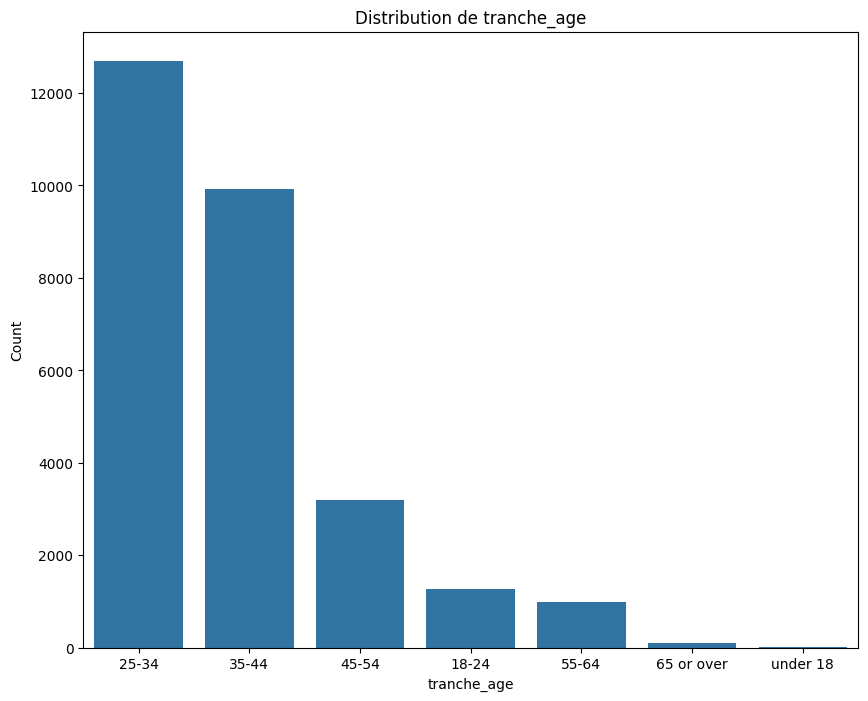

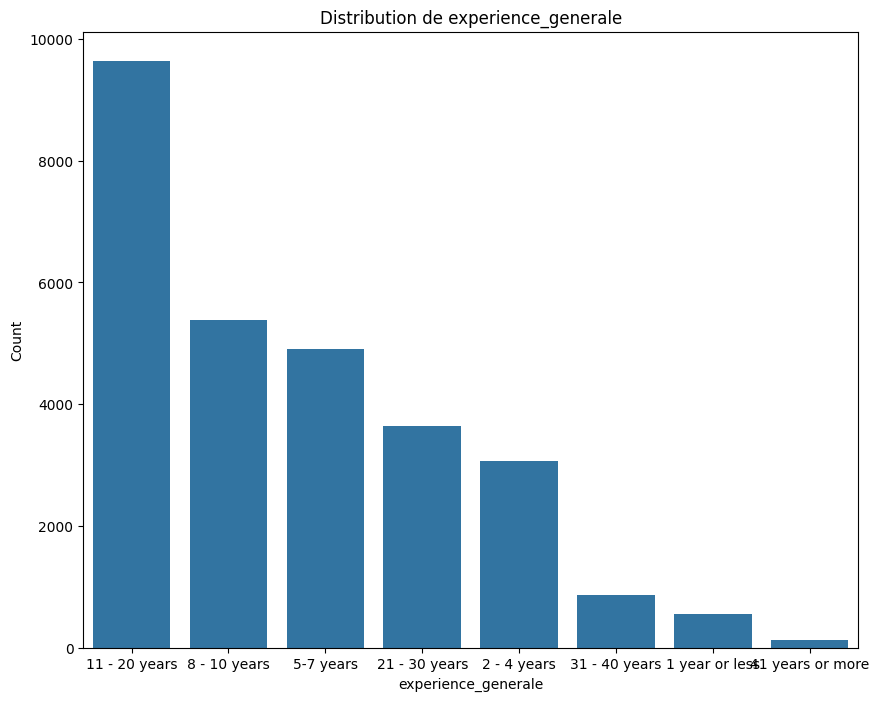

Devises présentes :
devise
USD        23469
CAD         1675
GBP         1593
EUR          652
AUD/NZD      505
Name: count, dtype: int64
count    2.738900e+04
mean     2.586639e+05
std      2.719968e+07
min      0.000000e+00
25%      5.356000e+04
50%      7.500000e+04
75%      1.070000e+05
max      4.500052e+09
Name: salaire_usd, dtype: float64
count    2.738900e+04
mean     2.586639e+05
std      2.719968e+07
min      0.000000e+00
25%      5.356000e+04
50%      7.500000e+04
75%      1.070000e+05
max      4.500052e+09
Name: salaire_usd, dtype: float64


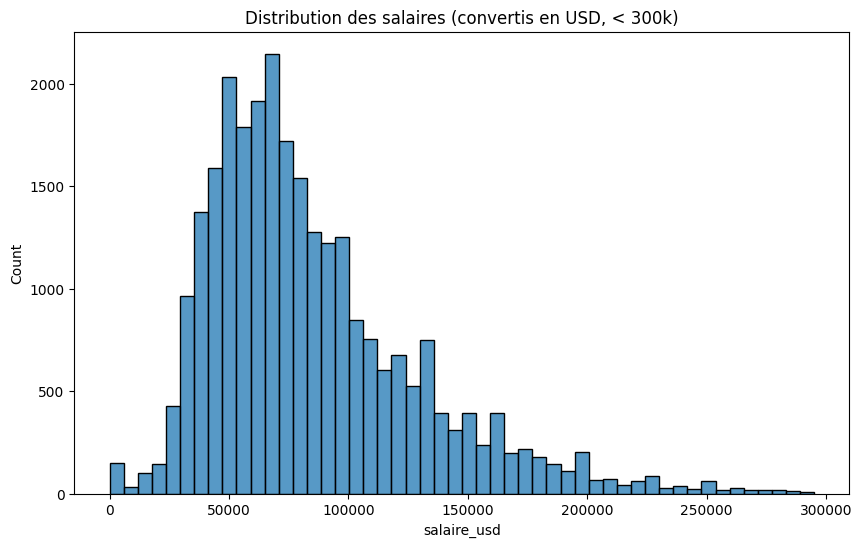

In [15]:
# On regarde la distribution des ages
visualisation_distribution_donnees(df_colonnes, "tranche_age", "bar")

# On regarde l'expérience générale
visualisation_distribution_donnees(df_colonnes, "experience_generale", "bar")

# Nettoyage de la colonne salaire
# Le salaire est en texte avec des virgules, il faut le convertir en nombre
def nettoyer_salaire(valeur):
    if isinstance(valeur, str):
        valeur = valeur.replace(",", "") # on enleve la virgule
        try:
            return float(valeur)
        except:
            return None # si ça marche pas on met vide
    return valeur

df_colonnes["salaire_annuel_clean"] = df_colonnes["salaire_annuel"].apply(nettoyer_salaire)

# Gestion des devises
# On voit qu'il y a plusieurs devises, pour comparer on va tout mettre en USD (approximativement)
print("Devises présentes :")
print(df_colonnes["devise"].value_counts().head())

taux_change = {
    "USD": 1.0,
    "GBP": 1.35,
    "EUR": 1.1,
    "CAD": 0.75,
    "AUD": 0.70
}

def convertir_en_usd(row):
    salaire = row["salaire_annuel_clean"]
    devise = row["devise"]
    
    if pd.isna(salaire):
        return None
    
    if devise in taux_change:
        return salaire * taux_change[devise]
    else:
        return None # On ignore les devises trop rares pour l'instant

df_colonnes["salaire_usd"] = df_colonnes.apply(convertir_en_usd, axis=1)

# On supprime les lignes où on a pas pu calculer le salaire
df_clean = df_colonnes.dropna(subset=["salaire_usd"])

# On regarde ce que ça donne
print(df_clean["salaire_usd"].describe())

# Petit histogramme des salaires (on filtre les valeurs extremes pour y voir clair)
plt.figure(figsize=(10,6))
# Correction : utilisation de 'sea' au lieu de 'sns' car importé comme 'import seaborn as sea' plus haut
sea.histplot(df_clean[df_clean["salaire_usd"] < 300000]["salaire_usd"], bins=50)
plt.title("Distribution des salaires (convertis en USD, < 300k)")
plt.show()

## 5. Traitement du texte et 6. Transformation

On va nettoyer un peu les intitulés de poste et transformer les catégories en chiffres pour pouvoir utiliser des algos dessus.

In [25]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

# 5. Traitement du texte (NLP)
# On s'assure d'avoir les ressources NLTK (nécessaire pour le TP)
# On télécharge les paquets nécessaires (punkt pour tokenisation, wordnet/omw pour lemmatisation)
# L'option quiet=True évite de spammer la console si c'est déjà là
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True) # Nécessaire pour certaines versions récentes
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True) # Nécessaire pour le lemmatizer

# On utilise la lemmatisation pour réduire les mots à leur racine
lemmatizer = WordNetLemmatizer()

def nlp_processing(text):
    if isinstance(text, str):
        # On met en minuscule
        text = text.lower()
        # Tokenization : on découpe en mots
        try:
            tokens = word_tokenize(text)
        except LookupError:
            # Fallback si punkt n'est pas trouvé malgré le download
            tokens = text.split()
            
        # Lemmatization et filtre (on garde que les mots alphanumériques)
        tokens_clean = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum()]
        return " ".join(tokens_clean)
    return ""

print("Traitement NLP en cours sur les intitulés de poste...")
# On utilise .loc pour éviter les warnings de copie
df_clean.loc[:, "intitule_poste_nlp"] = df_clean["intitule_poste"].apply(nlp_processing)
print("Exemple avant/après NLP :")
print(df_clean[["intitule_poste", "intitule_poste_nlp"]].head())

# 6. & 7. Transformation des données (Encoding)
# On utilise LabelEncoder pour transformer les textes (tranche d'age, diplome...) en nombres
le = LabelEncoder()

colonnes_a_encoder = ["tranche_age", "experience_generale", "experience_domaine", "diplome", "industrie_travail"]

for col in colonnes_a_encoder:
    # On remplit les vides par "Inconnu"
    df_clean.loc[:, col] = df_clean[col].fillna("Inconnu")
    # On crée une nouvelle colonne avec le code
    df_clean.loc[:, col + "_code"] = le.fit_transform(df_clean[col])

print("Encodage terminé.")
print(df_clean[["tranche_age", "tranche_age_code"]].head())

Traitement NLP en cours sur les intitulés de poste...
Exemple avant/après NLP :
                             intitule_poste  \
0        Research and Instruction Librarian   
1  Change & Internal Communications Manager   
2                      Marketing Specialist   
3                           Program Manager   
4                        Accounting Manager   

                      intitule_poste_nlp  
0     research and instruction librarian  
1  change internal communication manager  
2                   marketing specialist  
3                        program manager  
4                     accounting manager  
Encodage terminé.
  tranche_age  tranche_age_code
0       25-34                 1
1       25-34                 1
2       25-34                 1
3       25-34                 1
4       25-34                 1
Exemple avant/après NLP :
                             intitule_poste  \
0        Research and Instruction Librarian   
1  Change & Internal Communications Manager   
2 

C:\Users\darkf\AppData\Local\Temp\ipykernel_31712\4126443786.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, "intitule_poste_nlp"] = df_clean["intitule_poste"].apply(nlp_processing)
C:\Users\darkf\AppData\Local\Temp\ipykernel_31712\4126443786.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, col + "_code"] = le.fit_transform(df_clean[col])
C:\Users\darkf\AppData\Local\Temp\ipykernel_31712\4126443786.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy

## 8. & 9. Manifold Learning (Réduction de dimension)

On va essayer de visualiser les données en 2D avec une PCA pour voir si des groupes se forment.

--- Interprétation ---
Avec ce dataset nettoyé, on pourrait envisager :
1. De la Régression : Prédire le 'salaire_usd' en fonction de l'expérience et du poste.
2. De la Classification : Prédire le 'niveau d'étude' (diplome) en fonction du salaire et du poste.
----------------------
Exécution de la PCA...
Erreur de reconstruction PCA (MSE) : 0.3706
Exécution du t-SNE (sur échantillon de 2000 points)...


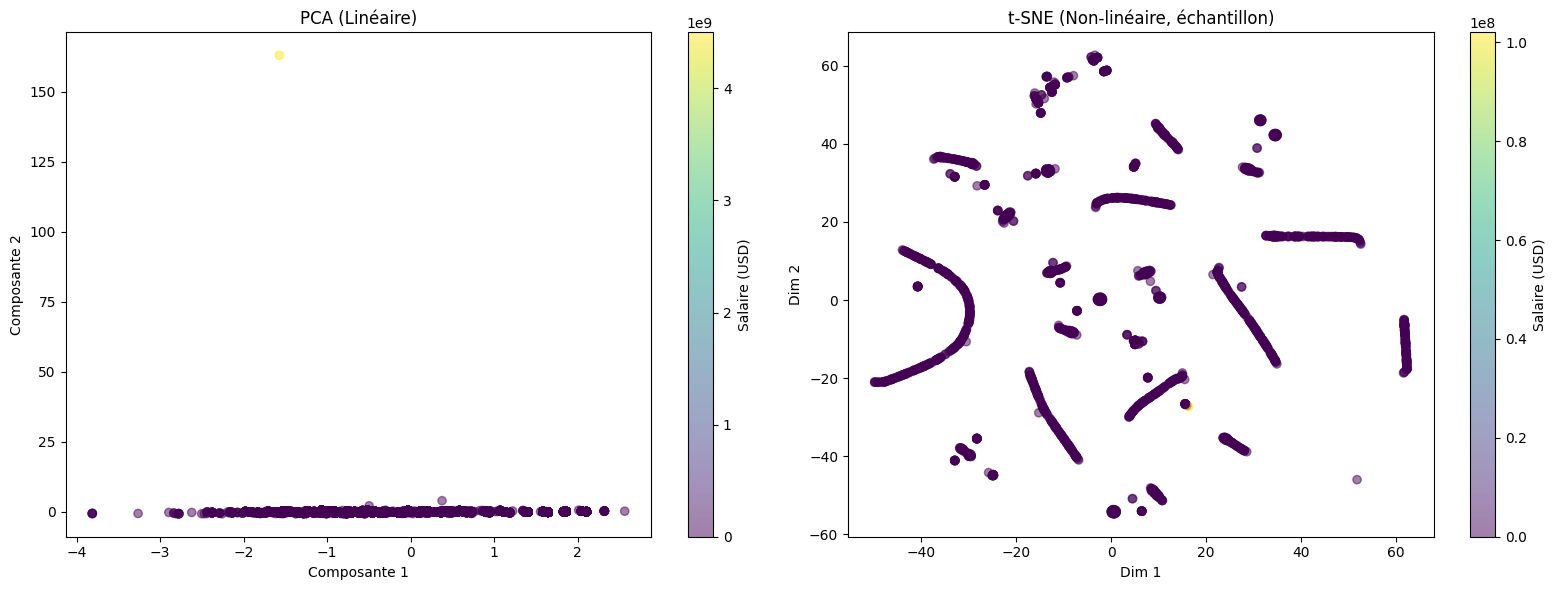

Analyse : La PCA montre une direction principale fortement corrélée au salaire.
Le t-SNE essaie de former des clusters locaux, ce qui suggère des groupes de profils similaires (ex: même niveau d'expérience/salaire).


In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np

# 2. Interprétation (Réponse à la question sur les problèmes d'apprentissage)
print("--- Interprétation ---")
print("Avec ce dataset nettoyé, on pourrait envisager :")
print("1. De la Régression : Prédire le 'salaire_usd' en fonction de l'expérience et du poste.")
print("2. De la Classification : Prédire le 'niveau d'étude' (diplome) en fonction du salaire et du poste.")
print("----------------------")

# 8. Manifold Learning
# On choisit nos colonnes pour l'analyse
features = ["salaire_usd", "tranche_age_code", "experience_generale_code", "experience_domaine_code"]
data_for_manifold = df_clean[features]

# Normalisation importante pour ces algos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_manifold)

# Algo 1 : PCA
print("Exécution de la PCA...")
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Calcul de l'erreur de reconstruction (demandé dans le TP)
data_reconstructed = pca.inverse_transform(data_pca)
reconstruction_error = np.mean((data_scaled - data_reconstructed) ** 2)
print(f"Erreur de reconstruction PCA (MSE) : {reconstruction_error:.4f}")

# Algo 2 : t-SNE (Non-linéaire)
# On prend un échantillon car t-SNE est très lent sur tout le dataset
print("Exécution du t-SNE (sur échantillon de 2000 points)...")
indices_sample = np.random.choice(data_scaled.shape[0], 2000, replace=False)
data_sample = data_scaled[indices_sample]
salaires_sample = df_clean["salaire_usd"].iloc[indices_sample]

tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
data_tsne = tsne.fit_transform(data_sample)

# 9. Visualisation
plt.figure(figsize=(16, 6))

# Plot PCA
plt.subplot(1, 2, 1)
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.5, c=df_clean["salaire_usd"], cmap="viridis")
plt.colorbar(label="Salaire (USD)")
plt.title("PCA (Linéaire)")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")

# Plot t-SNE
plt.subplot(1, 2, 2)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], alpha=0.5, c=salaires_sample, cmap="viridis")
plt.colorbar(label="Salaire (USD)")
plt.title("t-SNE (Non-linéaire, échantillon)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")

plt.tight_layout()
plt.show()

print("Analyse : La PCA montre une direction principale fortement corrélée au salaire.")
print("Le t-SNE essaie de former des clusters locaux, ce qui suggère des groupes de profils similaires (ex: même niveau d'expérience/salaire).")